In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

In [3]:
import sklearn
import seaborn as sns

In [4]:
from sklearn import preprocessing, linear_model, metrics

In [5]:
import datetime

### Loading data

In [6]:
data                 = pd.read_csv( '../data/rawData/data.csv' )

### Data engineering - age

In [7]:
def getAgeGroup(age):
    if   age >= 20 and age < 30:
        return '20-30'
    elif age >= 30 and age < 40:
        return '30-40'
    elif age >= 40 and age < 50:
        return '40-50'
    elif age >= 50 and age < 60:
        return '50-60'
    else:
        return '60&Above'
    
currentYear          = datetime.datetime.now().year
data['age']          = data['Birth_Year'].apply(lambda y: currentYear - y)
data['age_group']    = data['age'].apply(lambda age: getAgeGroup(age))

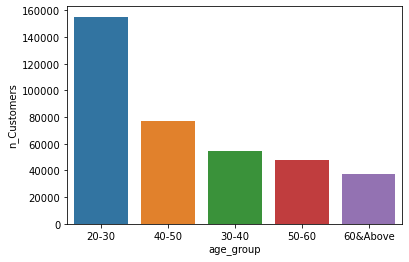

In [41]:
aggData = data['age_group'].value_counts() \
                           .reset_index() \
                           .rename({'index': 'age_group', 'age_group': 'n_Customers'}, axis=1)
ax      = sns.barplot(x="age_group", y="n_Customers", data=aggData)

### Data engineering - Engine_Capacity

In [8]:
data['capacity_num'] = data['Engine_Capacity'].apply(lambda s: s.replace('cc', ''))
data['capacity_num'].value_counts()

1600    46781
2600    46660
1500    46627
2800    46580
2200    46439
1800    46323
2000    46314
1000    45995
Name: capacity_num, dtype: int64

### Data engineering - Gender

In [9]:
data['gender_num'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['gender_num'].value_counts()

0    200810
1    170909
Name: gender_num, dtype: int64

### Data engineering - Any_Claim

In [10]:
data['any_claim_num'] = data['Any_Claim'].map({'No': 0, 'Yes': 1})
data['any_claim_num'].value_counts()

1    186849
0    184870
Name: any_claim_num, dtype: int64

In [11]:
numericalColumns   = ['Driving_Exp', 'Vehicle_Age', 'capacity_num']
categoricalColumns = ['Address_Region', 'Sales_Channel', 'age_group']
binaryColumns      = ['gender_num', 'Insured_Last_Year', 'any_claim_num']

In [12]:
data_numeric       = data[ numericalColumns + binaryColumns ]
data_cat           = data[ categoricalColumns ]
data_label         = data['Willingness_to_renew']

### Min Max - Scaling

In [13]:
scaler             = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(data_numeric)
data_scaled        = scaler.transform( data_numeric )
data_scaled        = pd.DataFrame( data_scaled, columns=data_numeric.columns )

### Categorical variable - encoding

In [14]:
encoder            = preprocessing.OneHotEncoder( sparse=False )
encoder.fit( data_cat )
encoder.categories_

[array(['Central', 'East', 'North', 'North East', 'West'], dtype=object),
 array(['Affiliate', 'Affinity', 'Email', 'Website'], dtype=object),
 array(['20-30', '30-40', '40-50', '50-60', '60&Above'], dtype=object)]

In [15]:
encodedColumns     = []
for arr in encoder.categories_:
    encodedColumns.extend(arr.tolist())
encodedColumns

['Central',
 'East',
 'North',
 'North East',
 'West',
 'Affiliate',
 'Affinity',
 'Email',
 'Website',
 '20-30',
 '30-40',
 '40-50',
 '50-60',
 '60&Above']

In [16]:
data_encoded       = encoder.transform( data_cat )
data_encoded       = pd.DataFrame( data_encoded, columns=encodedColumns )

In [17]:
data_encoded[:3]

,Central,East,North,North East,West,Affiliate,Affinity,Email,Website,20-30,30-40,40-50,50-60,60&Above
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
data_engineered   = pd.concat([data_scaled, data_encoded], axis=1)

In [19]:
### remove redundant dataframe
del data_numeric, data_cat, data_scaled, data_encoded

In [20]:
data_engineered[:5]

,Driving_Exp,Vehicle_Age,capacity_num,gender_num,Insured_Last_Year,any_claim_num,Central,East,North,North East,West,Affiliate,Affinity,Email,Website,20-30,30-40,40-50,50-60,60&Above
0,0.666667,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.444444,0.363636,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.888889,0.636364,0.888889,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.111111,0.909091,0.555556,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.888889,0.909091,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### filter customers who were insured with us

In [21]:
insuredIndexes     = data_engineered[ data_engineered['Insured_Last_Year']==1 ].index
nonInsuredIndexes  = data_engineered[ data_engineered['Insured_Last_Year']==0 ].index

In [22]:
data_insured       = data_engineered.loc[ insuredIndexes, ].reset_index(drop=True)
insured_label      = data_label.loc[ insuredIndexes ].reset_index(drop=True)

data_no_insured    = data_engineered.loc[ nonInsuredIndexes, ].reset_index(drop=True)
no_insured_label   = data_label.loc[ nonInsuredIndexes ].reset_index(drop=True)

In [23]:
data_insured.shape, insured_label.shape, data_no_insured.shape, no_insured_label.shape

((170959, 20), (170959,), (200760, 20), (200760,))

In [24]:
random_state       = 1909

### Let's start with customers who had insurance with us last year

In [25]:
data_insured_X     = data_insured.drop(labels='Insured_Last_Year', axis=1).copy(deep=True)

In [26]:
lr                 = linear_model.LogisticRegression(penalty='l1', solver='liblinear', 
                                                     class_weight='balanced', random_state=random_state)

In [27]:
lr.fit(data_insured_X, insured_label)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=1909,
                   solver='liblinear')

In [28]:
pred               = lr.predict_proba( data_insured_X )[:, 1]

AUC score is pretty good for the linear model (79%)

In [29]:
metrics.roc_auc_score(insured_label, pred)

0.8404244024648946

In [30]:
factorImportance   = pd.DataFrame( zip(data_insured_X.columns, lr.coef_[0]), columns=['feature', 'coef'] )
factorImportance   = factorImportance.sort_values('coef', ascending=False).reset_index(drop=True)
factorImportance

,feature,coef
0,any_claim_num,3.131287
1,30-40,0.661827
2,40-50,0.387579
3,capacity_num,0.170622
4,Affiliate,0.149648
5,North East,0.079239
6,Central,0.000000
7,Email,0.000000
8,Website,-0.010344
9,East,-0.016687


In [31]:
factorImportance   = factorImportance.rename({'coef': 'coef_prev_ins_cust'}, axis=1)

### Let's start with customers who didn't have insurance with us last year

In [32]:
data_no_insured_X  = data_no_insured.drop(labels='Insured_Last_Year', axis=1).copy(deep=True)

In [33]:
lr2                = linear_model.LogisticRegression(penalty='l1', solver='liblinear', 
                                                     class_weight='balanced', random_state=random_state)

In [34]:
lr2.fit(data_no_insured_X, no_insured_label)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=1909,
                   solver='liblinear')

In [35]:
pred2              = lr2.predict_proba( data_no_insured_X )[:, 1]

In [36]:
metrics.roc_auc_score(no_insured_label, pred2)

0.673714787011865

In [37]:
factorImportance2  = pd.DataFrame( zip(data_no_insured_X.columns, lr2.coef_[0]), columns=['feature', 'coef'] )
factorImportance2  = factorImportance2.sort_values('coef', ascending=False).reset_index(drop=True)
factorImportance2

,feature,coef
0,any_claim_num,1.998197
1,30-40,0.277982
2,Website,0.139278
3,North,0.046186
4,Driving_Exp,0.016266
5,40-50,0.000000
6,North East,0.000000
7,Affiliate,0.000000
8,capacity_num,-0.005747
9,Vehicle_Age,-0.038281


In [38]:
factorImportance2  = factorImportance2.rename({'coef': 'coef_prev_not_ins_cust'}, axis=1)

In [39]:
factorImportance_combi = pd.merge( factorImportance, factorImportance2, on='feature', how='inner' )

In [40]:
factorImportance_combi

,feature,coef_prev_ins_cust,coef_prev_not_ins_cust
0,any_claim_num,3.131287,1.998197
1,30-40,0.661827,0.277982
2,40-50,0.387579,0.000000
3,capacity_num,0.170622,-0.005747
4,Affiliate,0.149648,0.000000
5,North East,0.079239,0.000000
6,Central,0.000000,-0.182261
7,Email,0.000000,-0.233576
8,Website,-0.010344,0.139278
9,East,-0.016687,-0.061575
